## Análisis Precipitación Total Parque Nacional Cerro Saroche

**PROYECTO:** SISTEMA PARA EL SEGUIMIENTO DE ECOSISTEMAS VENEZOLANOS \
**AUTOR:** Javier Martinez

Directorio de trabajo

In [ ]:
import os

print('> Directorio actual: ', os.getcwd())  
os.chdir('../')
print('> Directorio actual: ', os.getcwd()) 

In [ ]:
from utils.MONGO import CONEXION
from utils.UTILS import *
from datetime import datetime
import pandas as pd

from tensorflow import keras

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Creando Coenxión con Mongo DB

In [ ]:
# Creando la conexión con MongoDB
db = CONEXION.conexion()
db.list_collection_names()

['meteorological', 'estimateSSTNino34', 'SSTNino34']

# Descargando la Información Precipitación

In [ ]:
# Parque
park = 'cerro_saroche'

# Realizando consulta
meteorological = db.meteorological.find({"park":park})

# Generando pandas dataframe
data_pandas = pd.DataFrame([file for file in meteorological])
data_pandas['periodo'] = data_pandas.time.apply(lambda x: datetime.fromordinal(x))
data_pandas['mes_year'] =  data_pandas['periodo'].dt.strftime('%B-%Y')
data_pandas.index = pd.to_datetime(data_pandas.periodo)
data_pandas.head()

,_id,id_point,park,time,elevacion_maxima,elevacion_media,elevacion_mediana,latitud,longitud,ndvi_maxima,ndvi_media,ndvi_mediana,precipitacion_mm,time_actualizacion,periodo,mes_year
periodo,,,,,,,,,,,,,,,,
1970-01-01,633988a2eed0e0231b327c97,1,cerro_saroche,719163,921.0,508.541046,491.0,10.31,-69.83,NaN,NaN,NaN,0.913065,738430,1970-01-01,January-1970
1970-01-01,633988a2eed0e0231b327ca7,2,cerro_saroche,719163,1000.0,625.942932,614.0,10.31,-69.73,NaN,NaN,NaN,0.958915,738430,1970-01-01,January-1970
1970-01-01,633988a2eed0e0231b327cc0,3,cerro_saroche,719163,1025.0,731.954834,731.0,10.31,-69.63,NaN,NaN,NaN,1.026073,738430,1970-01-01,January-1970
1970-01-01,633988a2eed0e0231b327ccc,4,cerro_saroche,719163,1103.0,761.129150,737.0,10.31,-69.53,NaN,NaN,NaN,1.095035,738430,1970-01-01,January-1970
1970-01-01,633988a3eed0e0231b327cdc,5,cerro_saroche,719163,1202.0,726.967285,709.0,10.31,-69.43,NaN,NaN,NaN,1.203287,738430,1970-01-01,January-1970


In [ ]:
# Registros
print(data_pandas.shape)

(9435, 16)


In [ ]:
# Data disponible
print(data_pandas.index.min())
print(data_pandas.index.max())

1970-01-01 00:00:00
2022-05-01 00:00:00


In [ ]:
DIR = './cerro_saroche/'

In [ ]:
# Cantidad de registros
# park_points = data_pandas[[ 'id_point','latitud', 'longitud','precipitacion_mm']]\
#                 .groupby(['id_point','latitud', 'longitud'],as_index=False)\
#                 .count()

# # Guardando resumen de experimentos
# park_points.to_csv(DIR + 'summary/poinst.csv')
# park_points

# Estudio Precipitación

In [ ]:
pd_precipitacion = data_pandas[['id_point', 'latitud', 'longitud',
                                'precipitacion_mm']]
pd_precipitacion.head()

,id_point,latitud,longitud,precipitacion_mm
periodo,,,,
1970-01-01,1,10.31,-69.83,0.913065
1970-01-01,2,10.31,-69.73,0.958915
1970-01-01,3,10.31,-69.63,1.026073
1970-01-01,4,10.31,-69.53,1.095035
1970-01-01,5,10.31,-69.43,1.203287


Aplicando transformación

In [ ]:
months = 1

list_data = []

for id in pd_precipitacion.id_point.unique().tolist():

    data = pd_precipitacion.query(f'id_point=={id}')

    y_dif = []
    y_pro = []
    for t in data.index[1:]:

        dif_preci = data[data.index==t]['precipitacion_mm'].values[0] - data[data.index==(t - pd.DateOffset(months=months))]['precipitacion_mm'].values[0] 
        pro_preci = dif_preci/data[data.index==(t - pd.DateOffset(months=months))]['precipitacion_mm'].values[0] 

        y_dif.append(dif_preci)
        y_pro.append(pro_preci)

    data_trans = data[1:]
    data_trans['dif_precipitacion_mm'] = y_dif
    data_trans['pro_precipitacion_mm'] = y_pro

    list_data.append(data_trans)

pd_precipitacion_trans = pd.concat(list_data)

# Cargando data SST

In [ ]:
# Realizando consulta
data_sst = db.estimateSSTNino34.find()

# Generando pandas dataframe
pd_sst = pd.DataFrame([file for file in data_sst])[['oni','time']]
pd_sst['periodo'] = pd_sst.time.apply(lambda x: datetime.fromordinal(x))
pd_sst.index = pd.to_datetime(pd_sst.periodo)
pd_sst

pd_sst.head()

,oni,time,periodo
periodo,,,
1950-01-01,-1.470000,711858,1950-01-01
1950-02-01,-1.336667,711889,1950-02-01
1950-03-01,-1.163333,711917,1950-03-01
1950-04-01,-1.180000,711948,1950-04-01
1950-05-01,-1.070000,711978,1950-05-01


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
sst_scaler = MinMaxScaler()

sst_scaler.fit(pd_sst[['oni']])

pd_sst['oni_trans']  = sst_scaler.transform(pd_sst[['oni']])
#pd_sst['oni_trans']  = np.sqrt(pd_sst['oni_trans'] )

<AxesSubplot:xlabel='periodo'>

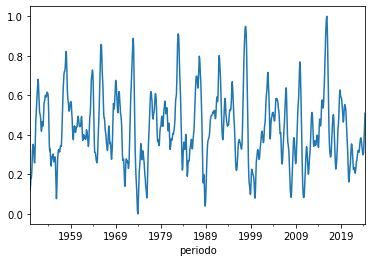

In [ ]:
pd_sst['oni_trans'].plot()

# Integrando base de datos

In [ ]:
# Entrenamiento
pd_model = pd.merge(pd_precipitacion_trans.reset_index(drop=False),pd_sst[['oni_trans']].reset_index(drop=False),
                    on=['periodo'],
                    how='left'
                    )

# Pronostico
pd_sst_pron = pd_sst[['periodo','oni_trans']][pd_sst.periodo > pd_model.periodo.max()].copy()

In [ ]:
pd_model[[ 'id_point','latitud', 'longitud','oni_trans']]\
                .groupby(['id_point','latitud', 'longitud'],as_index=False)\
                .count()

,id_point,latitud,longitud,oni_trans
0,1,10.31,-69.83,628
1,2,10.31,-69.73,628
2,3,10.31,-69.63,628
3,4,10.31,-69.53,628
4,5,10.31,-69.43,628
5,6,10.21,-69.83,628
6,7,10.21,-69.73,628
7,8,10.21,-69.63,628
8,9,10.21,-69.53,628
9,10,10.21,-69.43,628


# Ajustando modelo NARX

Modelo según ID point

In [ ]:
id_point = 1
#y_output = 'minmax_dif_precipitacion_mm'
y_output = 'minmax_pro_precipitacion_mm'
exogena = 'oni_trans'

prediction_order = 12 # rango de prediccion
auto_order = 13*12 # componente autoregresiva
exog_order =  5*12# componente exogena qm
exog_delay = 1# componente exogena dm

In [ ]:
pd_model

,periodo,id_point,latitud,longitud,precipitacion_mm,dif_precipitacion_mm,pro_precipitacion_mm,oni_trans
0,1970-02-01,1,10.31,-69.83,0.081278,-0.831787,-0.910983,0.506771
1,1970-03-01,1,10.31,-69.83,0.413783,0.332504,4.090928,0.497505
2,1970-04-01,1,10.31,-69.83,0.895653,0.481870,1.164550,0.476123
3,1970-05-01,1,10.31,-69.83,2.909450,2.013797,2.248411,0.444048
4,1970-06-01,1,10.31,-69.83,1.247108,-1.662342,-0.571359,0.369922
...,...,...,...,...,...,...,...,...
9415,2022-01-01,15,10.11,-69.43,0.160296,-0.320596,-0.666669,0.228083
9416,2022-02-01,15,10.11,-69.43,0.407593,0.247297,1.542748,0.234498
9417,2022-03-01,15,10.11,-69.43,0.842776,0.435183,1.067690,0.222381
9418,2022-04-01,15,10.11,-69.43,4.089661,3.246885,3.852606,0.205987


In [ ]:
pd_model_id = pd_model[pd_model.id_point==id_point]
pd_model_id.index = pd.to_datetime(pd_model_id.periodo)

In [ ]:
pre_scaler = MinMaxScaler()

pre_scaler.fit(pd_model_id[['pro_precipitacion_mm']])
#pre_scaler.fit(pd_model_id[['dif_precipitacion_mm']])

#pd_model_id[y_output]  = pre_scaler.transform(pd_model_id[['dif_precipitacion_mm']])
pd_model_id[y_output]  = pre_scaler.transform(pd_model_id[['pro_precipitacion_mm']])
pd_model_id[y_output] = pd_model_id[y_output].apply(lambda x: x**(1./3.))
# pd_model_id['minmax_pro_precipitacion_mm'] = np.log(pd_model['minmax_pro_precipitacion_mm'])
pd_model_id.head()

,periodo,id_point,latitud,longitud,precipitacion_mm,dif_precipitacion_mm,pro_precipitacion_mm,oni_trans,minmax_pro_precipitacion_mm
periodo,,,,,,,,,
1970-02-01,1970-02-01,1,10.31,-69.83,0.081278,-0.831787,-0.910983,0.506771,0.120336
1970-03-01,1970-03-01,1,10.31,-69.83,0.413783,0.332504,4.090928,0.497505,0.510382
1970-04-01,1970-04-01,1,10.31,-69.83,0.895653,0.481870,1.164550,0.476123,0.383010
1970-05-01,1970-05-01,1,10.31,-69.83,2.909450,2.013797,2.248411,0.444048,0.439023
1970-06-01,1970-06-01,1,10.31,-69.83,1.247108,-1.662342,-0.571359,0.369922,0.220023


<AxesSubplot:xlabel='periodo'>

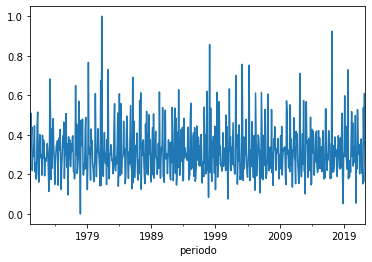

In [ ]:
pd_model_id['minmax_pro_precipitacion_mm'].plot()

Definiendo estructura de datos

In [ ]:
def split_data(pd_model_id,exog_order,auto_order,exog_delay,prediction_order):
    """
    Funcion para dale estructura a los datos
    """

    min_index = max([exog_order,auto_order])

    x_data = []
    y_data = []

    for t in pd_model_id[min_index:].index:

        #t = pd_model_id[min_index:].index.min()

        to_split = pd_model_id[[y_output,exogena]]
        to_split = to_split[(t-pd.DateOffset(months=auto_order)):t].copy()

        # Exogena
        x_exo = to_split[exogena][(t-pd.DateOffset(months=exog_delay+exog_order)):(t-pd.DateOffset(months=exog_delay+1))]\
                            .to_numpy()\
                            .astype(float)\
                            .reshape(-1)

        # Auto
        x_auto = to_split[y_output][:-1]\
                    .to_numpy()\
                    .astype(float)\
                    .reshape(-1)

        x_data.append(np.concatenate([x_exo, x_auto],axis=None))
        y_data.append(to_split[y_output][-1])

    x_data = np.array(x_data)
    y_data = np.array(y_data)

    return x_data, y_data

In [ ]:
x_data, y_data = split_data(pd_model_id,exog_order,auto_order,exog_delay,prediction_order)


print(x_data.shape)
print(y_data.shape)

(472, 216)
(472,)


Entrenamiento y validación

In [ ]:
x_train = x_data[:-prediction_order]
x_vasl = x_data[-prediction_order:]

y_train = y_data[:-prediction_order]
y_vasl = y_data[-prediction_order:]

print(x_train.shape)
print(x_vasl.shape)

print(y_train.shape)
print(y_vasl.shape)

(460, 216)
(12, 216)
(460,)
(12,)


Modelo NARX

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
# Metrícas
mae = keras.metrics.MeanAbsoluteError()
rmse = keras.metrics.RootMeanSquaredError()

In [ ]:
confi = {'Input':{'batch_size':None,
                'name':'input',
                'dtype':None,
                'sparse':None,
                'tensor':None,
                'ragged':None,
                'type_spec':None},
        'Dense':{'use_bias':True,
                'kernel_regularizer':None,
                'bias_regularizer':None,
                'activity_regularizer':None,
                'kernel_constraint':None,
                'bias_constraint':None
                }
        }

In [ ]:
total = int(2*x_train.shape[-1]/3)

int(2*total/3)

96

In [ ]:

n_neurons = [int(3*total/6), int(2*total/5),int(1*total/5),1]
print(n_neurons)
activation = ['sigmoid','sigmoid','sigmoid','sigmoid']
kernel_initializer = 'lecun_normal'
bias_initializer = 'zeros'
patience = 10
epochs=500


# Modelo
model = keras.models.Sequential()

# Entradas
model.add(keras.layers.Input(shape=(x_train.shape[-1],),
                                    batch_size = confi.get('Input').get('batch_size'),
                                    name = confi.get('Input').get('name'),
                                    dtype = confi.get('Input').get('dtype'),
                                    sparse = confi.get('Input').get('sparse'),
                                    tensor = confi.get('Input').get('tensor'),
                                    ragged = confi.get('Input').get('ragged'),
                                    type_spec = confi.get('Input').get('type_spec')
                                    ))

# Hidden Leyers
model.add(keras.layers.Dense(   units=n_neurons[0],
                                activation=activation[0],
                                use_bias = confi.get('Dense').get('use_bias'),
                                kernel_initializer=kernel_initializer,
                                bias_initializer=bias_initializer,
                                kernel_regularizer = confi.get('Dense').get('kernel_regularizer'),
                                bias_regularizer = confi.get('Dense').get('bias_regularizer'),
                                activity_regularizer = confi.get('Dense').get('activity_regularizer'),
                                kernel_constraint = confi.get('Dense').get('kernel_constraint'),
                                bias_constraint = confi.get('Dense').get('bias_constraint')
                                ))

model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(   units=n_neurons[1],
                                activation=activation[1],
                                use_bias = confi.get('Dense').get('use_bias'),
                                kernel_initializer=kernel_initializer,
                                bias_initializer=bias_initializer,
                                kernel_regularizer = confi.get('Dense').get('kernel_regularizer'),
                                bias_regularizer = confi.get('Dense').get('bias_regularizer'),
                                activity_regularizer = confi.get('Dense').get('activity_regularizer'),
                                kernel_constraint = confi.get('Dense').get('kernel_constraint'),
                                bias_constraint = confi.get('Dense').get('bias_constraint')
                                ))

#model.add(keras.layers.Dropout(0.05))


model.add(keras.layers.Dense(   units=n_neurons[2],
                                activation=activation[2],
                                use_bias = confi.get('Dense').get('use_bias'),
                                kernel_initializer=kernel_initializer,
                                bias_initializer=bias_initializer,
                                kernel_regularizer = confi.get('Dense').get('kernel_regularizer'),
                                bias_regularizer = confi.get('Dense').get('bias_regularizer'),
                                activity_regularizer = confi.get('Dense').get('activity_regularizer'),
                                kernel_constraint = confi.get('Dense').get('kernel_constraint'),
                                bias_constraint = confi.get('Dense').get('bias_constraint')
                                ))

#model.add(keras.layers.Dropout(0.05))

model.add(keras.layers.Dense(   units=n_neurons[3],
                                activation=activation[3],
                                use_bias = confi.get('Dense').get('use_bias'),
                                kernel_initializer=kernel_initializer,
                                bias_initializer=bias_initializer,
                                kernel_regularizer = confi.get('Dense').get('kernel_regularizer'),
                                bias_regularizer = confi.get('Dense').get('bias_regularizer'),
                                activity_regularizer = confi.get('Dense').get('activity_regularizer'),
                                kernel_constraint = confi.get('Dense').get('kernel_constraint'),
                                bias_constraint = confi.get('Dense').get('bias_constraint')
                                ))

#model.add(keras.layers.Dropout(0.05))

# Out
model.add(keras.layers.Dense(   units=1,
                                activation='linear',
                                # use_bias = confi.get('Dense').get('use_bias'),
                                kernel_initializer=kernel_initializer,
                                bias_initializer=bias_initializer,
                                # kernel_regularizer = confi.get('Dense').get('kernel_regularizer'),
                                # bias_regularizer = confi.get('Dense').get('bias_regularizer'),
                                # activity_regularizer = confi.get('Dense').get('activity_regularizer'),
                                # kernel_constraint = confi.get('Dense').get('kernel_constraint'),
                                # bias_constraint = confi.get('Dense').get('bias_constraint')
                                ))
                                

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[mae,rmse]) 

In [ ]:
callback = keras.callbacks.EarlyStopping(
                                            monitor="loss",
                                            min_delta=0,
                                            patience=patience,
                                            verbose=0,
                                            mode="min",
                                            baseline=None,
                                            restore_best_weights=False,
                                        )

Directorio experimento

In [ ]:
# experimento = f'experiments/narx/narx_prec_{id_point}_{len(n_neurons)}_{activation[0]}_{prediction_order}_{auto_order}_{exog_order}_{exog_delay}'

# try:
#     os.mkdir(f'{DIR}/{experimento}')
# except:
#     pass

Entrenamiento

In [ ]:
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=1,
                    verbose=0,
                    workers=2,
                    callbacks=[callback])

In [ ]:
print(f'Total epocas:{len(history.epoch)}')

Total epocas:177


Guardando experimento

In [ ]:
# model.save(f'{DIR}/{experimento}/narx_precipitacion_model.h5')
# # Save Pesos
# model.save_weights(f'{DIR}/{experimento}/narx_precipitacionweights.h5')

# # Save History
# import pickle
# with open(f'{DIR}/{experimento}/narx_precipitacion_history.pkl', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)

Evaluación entrenamiento

In [ ]:
min_index = max([exog_order,auto_order])

In [ ]:
# make predictions
trainPredict = model.predict(x_train, verbose=0).reshape(-1)
testPredict = model.predict(x_vasl, verbose=0).reshape(-1)

In [ ]:
# Data de test
trainind_pd = pd.DataFrame(trainPredict,
                            index = pd_model_id[min_index:(min_index+trainPredict.shape[0])].index,
                            columns=['prediction']
                            )
                            
trainind_pd[y_output] = y_train.reshape(-1)
trainind_pd['type'] = 'training'

trainind_pd['pro_precipitacion_mm'] = trainind_pd[y_output].apply(lambda x: x**3)
trainind_pd['pro_precipitacion_mm'] = pre_scaler.inverse_transform(trainind_pd[['pro_precipitacion_mm']])

trainind_pd['prediction_pro_precipitacion_mm'] = trainind_pd['prediction'].apply(lambda x: x**3)
trainind_pd['prediction_pro_precipitacion_mm'] = pre_scaler.inverse_transform(trainind_pd[['prediction_pro_precipitacion_mm']])


trainind_pd.head()

,prediction,minmax_pro_precipitacion_mm,type,pro_precipitacion_mm,prediction_pro_precipitacion_mm
periodo,,,,,
1983-02-01,0.294480,0.245718,training,-0.411836,-0.003886
1983-03-01,0.534409,0.446369,training,2.413069,4.840967
1983-04-01,0.578999,0.557533,training,5.629390,6.422274
1983-05-01,0.227767,0.230030,training,-0.513394,-0.526960
1983-06-01,0.234047,0.217980,training,-0.582564,-0.488658


In [ ]:
trainig_metrics = metrics(observado=trainind_pd.pro_precipitacion_mm,
                          prediccion=trainind_pd.prediction_pro_precipitacion_mm)
trainig_metrics

{'mape': 88.88185231988795,
 'mae': 0.3680117530144937,
 'mse': 0.7791166760100698,
 'rmse': 0.6070227948369801,
 'r2': 0.9288550846200507}

<AxesSubplot:xlabel='periodo'>

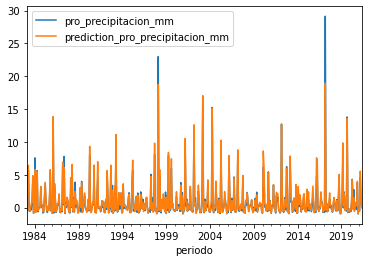

In [ ]:
trainind_pd[['pro_precipitacion_mm','prediction_pro_precipitacion_mm']].plot()

Evaluación validación

In [ ]:
# Data de Validacion
validation_pd = pd.DataFrame(testPredict,
                            index = pd_model_id[(min_index+trainPredict.shape[0]):(min_index+trainPredict.shape[0]+prediction_order)].index,
                            columns=['prediction']
                            )

validation_pd[y_output] = y_vasl.reshape(-1)
validation_pd['type'] = 'validation'


validation_pd['pro_precipitacion_mm'] = validation_pd[y_output].apply(lambda x: x**3)
validation_pd['pro_precipitacion_mm'] = pre_scaler.inverse_transform(validation_pd[['pro_precipitacion_mm']])

validation_pd['prediction_pro_precipitacion_mm'] = validation_pd['prediction'].apply(lambda x: x**3)
validation_pd['prediction_pro_precipitacion_mm'] = pre_scaler.inverse_transform(validation_pd[['prediction_pro_precipitacion_mm']])


# Validacion entrenamiento
validation_metrics = metrics(observado=validation_pd.pro_precipitacion_mm,
                          prediccion=validation_pd.prediction_pro_precipitacion_mm)
validation_metrics

{'mape': 115.3815142159297,
 'mae': 1.2902966132961622,
 'mse': 2.045949704554851,
 'rmse': 4.185910193568083,
 'r2': 0.3421459315599913}

<AxesSubplot:xlabel='periodo'>

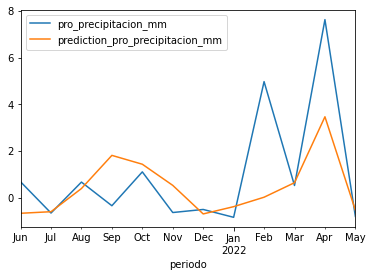

In [ ]:
validation_pd[['pro_precipitacion_mm','prediction_pro_precipitacion_mm']].plot()

Test

In [ ]:
def predict_one_stap_narx(model,data_predict,data_exogena,exog_order,auto_order,exog_delay,prediction_order):
  """
  Funcion para predecir a un paso
  """
  data_predict = data_predict.copy()
  data_predict['type'] = 'data_in'

  for t in data_exogena.index:
    
      x_data_test, y_data_test = split_data(data_predict,
                                          exog_order,
                                          auto_order,
                                          exog_delay,
                                          prediction_order)


      predit = model.predict(x_data_test[-1].reshape(1, x_data_test.shape[1]), verbose=0).reshape(-1)
      exo = data_exogena[data_exogena.index==t][exogena][0]

      data_test = pd.DataFrame({'periodo':t, y_output:predit, exogena:exo,'type':'data_out'},index=[0])
      data_test.index = pd.to_datetime(data_test.periodo)

      data_predict = pd.concat([data_predict,
                                data_test[list(data_predict)]
                              ])

  return data_predict

In [ ]:
data_predict = pd_model_id[pd_model_id.index<=trainind_pd.index.max()][[y_output,exogena]]
data_exogena = pd_model_id[pd_model_id.index>trainind_pd.index.max()][[exogena]]

pd_test = predict_one_stap_narx(model,data_predict,data_exogena,exog_order,auto_order,exog_delay,prediction_order)

pd_test = pd_test[pd_test.type=='data_out']
pd_test['type'] = 'test'

pd_test['prediction'] = pd_test[y_output]
pd_test[y_output] = pd_model_id[pd_model_id.index>=pd_test.index.min()][y_output]


pd_test['pro_precipitacion_mm'] = pd_test[y_output].apply(lambda x: x**3)
pd_test['pro_precipitacion_mm'] = pre_scaler.inverse_transform(pd_test[['pro_precipitacion_mm']])

pd_test['prediction_pro_precipitacion_mm'] = pd_test['prediction'].apply(lambda x: x**3)
pd_test['prediction_pro_precipitacion_mm'] = pre_scaler.inverse_transform(pd_test[['prediction_pro_precipitacion_mm']])



# Validacion entrenamiento
test_metrics = metrics(observado=pd_test.pro_precipitacion_mm,
                        prediccion=pd_test.prediction_pro_precipitacion_mm)

test_metrics

{'mape': 226.16215193493528,
 'mae': 2.278049235027482,
 'mse': 3.566273473419379,
 'rmse': 12.718306487214724,
 'r2': -0.9987981775474458}

<AxesSubplot:xlabel='periodo'>

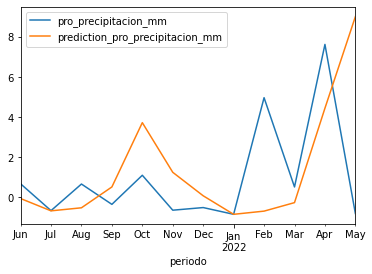

In [ ]:
pd_test[['pro_precipitacion_mm','prediction_pro_precipitacion_mm']].plot()